### 理解Q学习算法，练习Keras实现 DQN网络  (！注意使用DeepL-3.10服务！)
#### 要求：
1）设计DQN网络，生成policy_net和target_net<BR>
2）调整Q学习算法参数，提高倒立摆保持时间。(可以尝试利用env提供的信息改进reward策略)

#### 考核办法：
训练100epoch后的性能表现,取保持时间最大的一次（80为及格线，160以上优秀）

Gym makes interacting with the game environment really simple:

next_state, reward, done, info = env.step(action)
Here, action can be either 0 or 1. If we pass those numbers, env, which represents the game environment, will emit the results. done is a boolean value telling whether the game ended or not. next_state space handles all possible state values:
(
[Cart Position from -4.8 to 4.8],
[Cart Velocity from -Inf to Inf],
[Pole Angle from -24° to 24°注意，得到的实际数值是弧度!],
[Pole Velocity At Tip from -Inf to Inf]
)

Episode Termination:（OR condition）
Pole Angle is more than 12 degrees
Cart Position is more than 2.4

In [ ]:
%matplotlib notebook
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from tensorflow import keras
from keras import layers,Sequential
import tensorflow as tf
# #Windows调试时!!删除下面2行！！
# from pyvirtualdisplay import Display
# Display().start()

env = gym.make('CartPole-v0',
               render_mode='rgb_array').unwrapped
env.reset()

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### 请在下面设计DQN网络结构
输入：图片shape=(40, 90, 3,)<BR>
输出：（2，）

In [ ]:
from keras.layers import Dense,Flatten

num_actions = 2

def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(40, 90, 3,))

    # 可以在这里用函数方式设计模型，也可以用sequential方式构建
    #提示最后一层：Dense(num_actions, activation="linear")
    x = Flatten()(inputs)
    x = Dense(64,activation='relu')(x)
    x = Dense(32,activation='relu')(x)
    x = Dense(16,activation='relu')(x)
    action = Dense(num_actions,activation='linear')(x)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
model_target = create_q_model()
model.summary()

In [ ]:
# from keras.layers import Dense

# num_actions = 2

# def create_q_model():
#     # Network defined by the Deepmind paper
#     # inputs = layers.Input(shape=(40, 90, 3,))

#     # 可以在这里用函数方式设计模型，也可以用sequential方式构建
#     #提示最后一层：Dense(num_actions, activation="linear")
#     qmodel = Sequential()
#     qmodel.add(Dense(32,activation='relu'))
#     qmodel.add(Dense(num_actions,activation='linear'))

#     qmodel.build(input_shape=(40, 90, 3,))
#     return qmodel


# # The first model makes the predictions for Q-values which are used to
# # make a action.
# model = create_q_model()
# # Build a target model for the prediction of future rewards.
# model_target = create_q_model()
# model.summary()

In [ ]:

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. 
    screen = env.render()
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen_height, screen_width,_ = screen.shape
    rawscreen=screen = screen[int(screen_height*0.4):int(screen_height * 0.8),:,:]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, slice_range, :]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen=tf.image.resize(screen,(40,90),method='bicubic')/255.0
    return screen,rawscreen
    

### 后续代码可以根据需要进行调参或修改细节

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
memory = ReplayMemory(10000)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
# Using huber loss for stability
loss_function = keras.losses.Huber()


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        action_probs =model(tf.expand_dims(state, 0), training=False)
        action = tf.argmax(action_probs[0]).numpy()
        return action
    else:
        return random.randrange(num_actions)


episode_durations = []
def plot_durations():
    ax1_2.clear()
    ax1_2.set_title('Training...')
    ax1_2.set_xlabel('Episode')
    ax1_2.set_ylabel('Duration')
    ax1_2.plot(episode_durations)
    fig1.canvas.draw()


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask =np.array( tuple(map(lambda s: s is not None,       batch.next_state)))
#     print(non_final_mask)
    non_final_next_states = tf.stack([s for s in batch.next_state
                                                if s is not None])
#     print(non_final_next_states.shape)
    state_sample = tf.stack(batch.state)

    action_sample =np.array( batch.action)
    rewards_sample =np.array(batch.reward)
    
    future_rewards = np.zeros(BATCH_SIZE,dtype='float32')
    future_rewards[non_final_mask] =tf.reduce_max( model_target.predict(non_final_next_states,verbose=0), axis=1)

    # Q value = reward + discount factor * expected future reward
    updated_q_values = rewards_sample + GAMMA * future_rewards

    # Create a mask so we only calculate loss on the updated Q-values
    masks = tf.one_hot(action_sample, num_actions)

    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = model(state_sample)

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))



In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

plt.ion()
fig1=plt.figure(figsize=(12,4))
ax1_1 = fig1.add_subplot(121)
ax1_2 = fig1.add_subplot(122)
init_screen,rawscreen = get_screen()
ax1_1.imshow(rawscreen)
fig1.canvas.draw()

num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = init_screen
    current_screen,_ = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        ss, reward, done, _, _ = env.step(action)
        
        ###尝试调整reward策略
        #reward=......
        if not done:
            reward = (t**(1/1.5)/16-0.4) + (-ss[3]**2/8+0.3)
        else:
            reward = -1
        if ss[1]*ss[2]<0:
            reward -= 0.5
        
        # Observe new state
        last_screen = current_screen
        current_screen,rawscreen = get_screen()

        ###以下显示动画会较严重影响运行速度，建议调试期间去除
        ax1_1.clear()
        if done:
            ax1_1.set_title('!!Fail!!')
        else:
            ax1_1.set_title('score:'+str(t+1))
        ax1_1.imshow(rawscreen)
        fig1.canvas.draw()
        plt.pause(0.001)
        ###显示动画会较严重影响运行速度，建议调试期间去除
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        model_target.set_weights(model.get_weights())

print('Complete')
# env.render()
env.close()
plt.ioff()
plt.show()
print('最好成绩：', max(episode_durations))

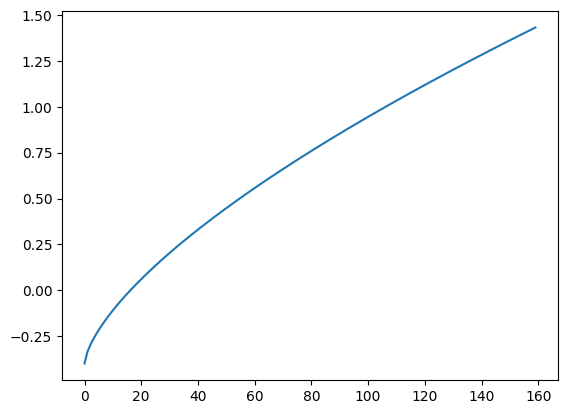

0.946521681269927

In [79]:
import matplotlib.pyplot as plt
import math
x = range(160)
y = []
for i in x:
    # y.append(math.tanh((i-80)/60)+0.4)
    y.append(i**(1/1.5)/16-0.4)
plt.plot(x,y)
plt.show()
y[100]

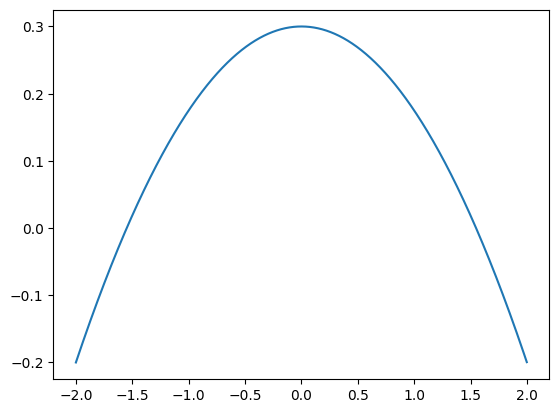

-0.2

In [77]:
import matplotlib.pyplot as plt
import math
x = []
y = []
for i in range(4000):
    v = i/1000-2
    x.append(v)
    y.append(-v**2/8+0.3)
plt.plot(x,y)
plt.show()
y[0]